In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time
from my_lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Get the file names of car and no-car images

In [2]:
train_cars, train_notcars = get_data_fileNames('train')
test_cars, test_notcars = get_data_fileNames('test')

#  Print some info about the datasets

In [3]:
data_info = data_look(train_cars, train_notcars)
print('TRAINING SET')
print('Number of cars images = ', data_info["n_cars"]) 
print('Number of no-cars images = ', data_info["n_notcars"])
print('Size = ', data_info["image_shape"])
print('Data type:', data_info["data_type"])

print()

data_info = data_look(test_cars, test_notcars)
print('TEST SET')
print('Number of cars images = ', data_info["n_cars"]) 
print('Number of no-cars images = ', data_info["n_notcars"])
print('Size = ', data_info["image_shape"])
print('Data type:', data_info["data_type"])


TRAINING SET
Number of cars images =  5697
Number of no-cars images =  6278
Size =  (64, 64, 3)
Data type: uint8

TEST SET
Number of cars images =  2431
Number of no-cars images =  2690
Size =  (64, 64, 3)
Data type: uint8


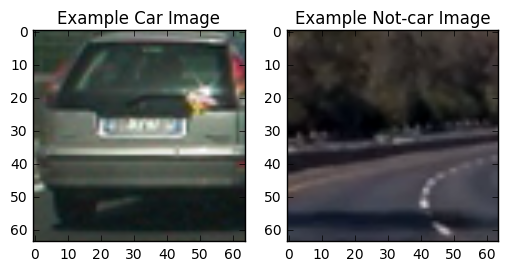

In [4]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(train_cars))
notcar_ind = np.random.randint(0, len(train_notcars))
    
# Read in car / not-car images
car_image = myimread(train_cars[car_ind])
notcar_image = myimread(train_notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

plt.show()

# Extract features for each dataset

The extracted features are asigned to a feature vector, as well as the labels vector are defined.

The posible features to be extracted are:

|         Features             |Characteristics  | 
|:----------------------------:|:---------------:| 
| Raw pixel intensity          | Color and shape | 
| Histogram of pixel intensity | Color only      |
| Gradients of pixel intensity  | Shape only      |

In [5]:
#Color space to work. Can be RGB, HSV, LUV, HLS, YUV, YCrCb
cSpace = 'HSV'

# Raw pixel intensity parameters setting
spatial_feat = True # Spatial features on or off
spatial_size = (8, 8) # Spatial binning dimensions

# Hisotgram of pixel intesity parameters setting
hist_feat = True # Histogram features on or off
hist_bins = 32    # Number of histogram bins

# Gradients of pixel intesity parameters setting
hog_feat = True # HOG features on or off
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
channel = 'ALL' # Can be 0, 1, 2, or "ALL"


# Extract features
t=time.time()
train_car_features = list_extract_features(train_cars, cSpace,
                                        spatial_feat, spatial_size,
                                        hist_feat, hist_bins,
                                        hog_feat, orient, pix_per_cell, cell_per_block, channel)

train_notcar_features = list_extract_features(train_notcars, cSpace,
                                        spatial_feat, spatial_size,
                                        hist_feat, hist_bins,
                                        hog_feat, orient, pix_per_cell, cell_per_block, channel)


test_car_features = list_extract_features(test_cars, cSpace,
                                        spatial_feat, spatial_size,
                                        hist_feat, hist_bins,
                                        hog_feat, orient, pix_per_cell, cell_per_block, channel)

test_notcar_features = list_extract_features(test_notcars, cSpace,
                                        spatial_feat, spatial_size,
                                        hist_feat, hist_bins,
                                        hog_feat, orient, pix_per_cell, cell_per_block, channel)


t2 = time.time()
print(round(t2-t, 2), 'Seconds extracting the features...')

# Define the features vector
X_train = np.vstack((train_car_features, train_notcar_features)).astype(np.float64)
X_test = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)

# Define the labels vector
y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

print('Feature vector length:', len(X_train[0]))

215.66 Seconds extracting the features...
Feature vector length: 5580


#  Features (data) normalization
This is to prevent to one tipe of featurure dominate the another ones

In [6]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# Shuffle the training data 

In [7]:
scaled_X_train, y_train = shuffle(scaled_X_train, y_train)

# Trainnig a Suport Vector Machine (SVM) classifier with linear kernel

## Choosing the optimal value of the C parameter

In [8]:
# values of the C parameter to test it
#C_range = np.linspace(1e-4, 2e-3, 15)
C_range = np.linspace(1e-5, 1e-4, 10)

train_scores = []
test_scores = []

t=time.time()
for C in C_range:
    estimator = LinearSVC(C=C)
    
    # train the clasifier with this data
    estimator.fit(scaled_X_train, y_train)
    
    y_pred_train = estimator.predict(scaled_X_train)
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    
    # calculate the test accuracy
    y_pred_test = estimator.predict(scaled_X_test)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
    
    train_scores.append(accuracy_train)
    test_scores.append(accuracy_test)

t2 = time.time()
print(round(t2-t, 2), 'Seconds trining with the C values points')

28.75 Seconds trining with the C values points


optimal value of C :  5e-05


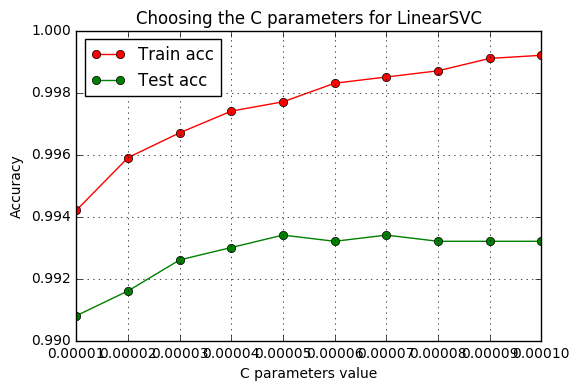

In [9]:
# Get the optimal value that maximize the score in the test set
opt_C = C_range[np.argmax(test_scores)]

print('optimal value of C : ', opt_C)

#Ploting the curve
plt.title('Choosing the C parameters for LinearSVC')
plt.plot(C_range, train_scores, 'o-', color="r",
             label="Train acc")
plt.plot(C_range, test_scores, 'o-', color="g",
         label="Test acc")
plt.xlabel("C parameters value")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc="best")

plt.show()

## Training the clasifier with optimal value of C

In [10]:
# Use a linear SVC 
svc = LinearSVC(C=opt_C)
# Check the training time for the SVC
X = np.concatenate((scaled_X_train, scaled_X_test))
y = np.concatenate((y_train, y_test))

t=time.time()
#svc.fit(X, y)
svc.fit(scaled_X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

2.76 Seconds to train SVC...


In [11]:
# Printing some measurements

y_pred = svc.predict(scaled_X_test)
print('Test Accuracy = ', accuracy_score(y_test, y_pred))
print('Test Precision = ', round(precision_score(y_test, y_pred), 4))
print('Test Recall = ', round(recall_score(y_test, y_pred), 4))
print('Test F1 = ', round(f1_score(y_test, y_pred), 4))

print( )
y_pred = svc.predict(scaled_X_train)
print('Train Accuracy = ', round(accuracy_score(y_train, y_pred), 4))


Test Accuracy =  0.993360671744
Test Precision =  0.9955
Test Recall =  0.9905
Test F1 =  0.993

Train Accuracy =  0.9977


## Plotting the learning curves to get some intuition of the classifier

9.34 Seconds to make learning curves points


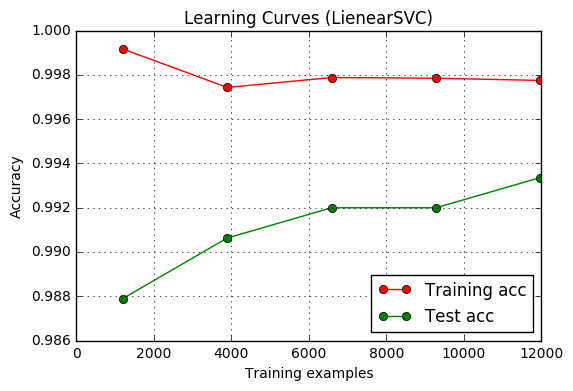

In [12]:
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import PredefinedSplit


# first make a unique train and validation set
X = np.concatenate((scaled_X_train, scaled_X_test))
y = np.concatenate((y_train, y_test))

# When using a validation set, set the test_fold to 0 for all samples 
# that are part of the validation set, and to -1 for all other samples
# http://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets
# http://stackoverflow.com/questions/31948879/using-explict-predefined-validation-set-for-grid-search-with-sklearn
test_fold = [-1] * len(y_train) + [0] * len(y_test)

ps = PredefinedSplit(test_fold)


title = "Learning Curves (LienearSVC)"

estimator = LinearSVC(C=opt_C)
t=time.time()
plot_learning_curve(estimator, title, X, y, cv=ps)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to make learning curves points')

plt.show()

## Training the clasifier with optimal value of C with all the samples

Because the leaning curves show that add more training examples may help, I decide to trainin the calsifier with all the examples

In [13]:
#"""
# TRain with all the examples
svc = LinearSVC(C=opt_C)
t=time.time()
svc.fit(X, y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
#"""

3.84 Seconds to train SVC...



# Sliding window on an image example

## First I provided manually the are where a car apear 

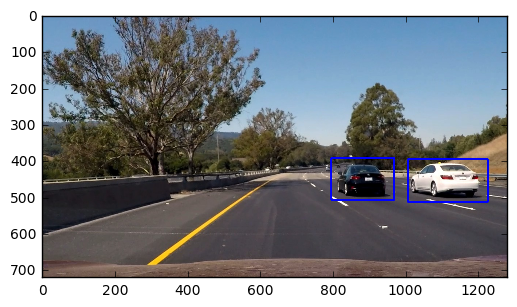

In [14]:
%matplotlib inline

image = myimread('test_images/test6.jpg')
draw_image = np.copy(image)

"""
# test windows for tes1.jpg or tes2.jpg or tes4.jpg
windows = [((809, 400), (953, 490)),
          ((1043, 400), (1273, 507)),
          ((489,438), (564,500))]

"""

"""
# test windows for test3.jpg
windows = [((872, 409), (961, 468)),
          ((1043, 400), (1273, 507)),
          ((489,438), (564,500))]
"""

"""
# test windows for test5.jpg
windows = [((1080, 387), (1280, 518)),
          ((801, 398), (955, 495)),
          ((489,438), (564,500))]
"""

#"""
# test windows for test6.jpg
windows = [((1005, 395), (1224, 514)),
          ((794, 392), (967, 508)),
          ((489,438), (564,500))]
#"""



hot_windows = search_windows(image, windows, svc, X_scaler, cSpace,
                            spatial_feat, spatial_size,
                            hist_feat, hist_bins,
                            hog_feat, orient, pix_per_cell, cell_per_block, channel)
            
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=4)

plt.imshow(window_img)
plt.show()

## Multiscale sliding window 

First with the slow method, then with the eficient implementation of HOG


In [15]:
# Read the image to be processed 
image = myimread('test_images/test6.jpg')

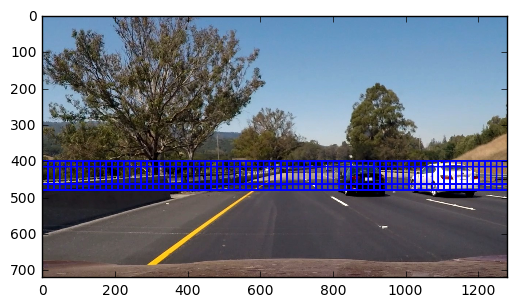

In [16]:
draw_image = np.copy(image)

y_start_stop_array = ((400,480), (400,560), (400,640))
xy_window_array    = ((64,64), (128,128), (192,192))
xy_overlap_array = ((0.75,0.75), (0.75, 0.75), (0.75, 0.75))

i = 0

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_array[i], 
                        xy_window=xy_window_array[i], xy_overlap=xy_overlap_array[i])
            
window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=4)

plt.imshow(window_img)
plt.show()

2.01 Seconds to make a prediction with the OLD implementation


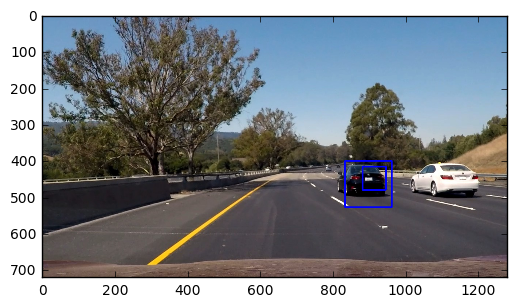

In [17]:
t=time.time()
draw_image = np.copy(image)


hot_windows_list = []
windows_list = []
for i in range(len(xy_window_array)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_array[i], 
                        xy_window=xy_window_array[i], xy_overlap=xy_overlap_array[i])


    hot_windows = search_windows(image, windows, svc, X_scaler, cSpace,
                            spatial_feat, spatial_size,
                            hist_feat, hist_bins,
                            hog_feat, orient, pix_per_cell, cell_per_block, channel)
    
    
    hot_windows_list.append(hot_windows)
    windows_list.append(windows)

box_list = [y for x in hot_windows_list for y in x]
w = [y for x in windows_list for y in x]

window_img = draw_boxes(draw_image, box_list, color=(0, 0, 255), thick=4)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to make a prediction with the OLD implementation')

plt.imshow(window_img)
plt.show()

0.61 Seconds to make a prediction with the NEW implementation


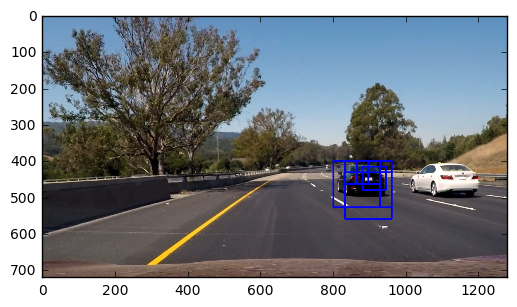

In [18]:
t=time.time()

draw_image = np.copy(image)

ystart = (400, 400, 400)
ystop =  (480, 560, 640)
scale = (1, 2, 3)
cells_per_step = (2, 2, 2)


hot_windows_list = []
for i in range(len(scale)):
    hot_windows = find_cars(image, ystart[i], ystop[i], scale[i], svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step[i])
    
    hot_windows_list.append(hot_windows)

box_list = [y for x in hot_windows_list for y in x]
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to make a prediction with the NEW implementation')


window_img = draw_boxes(draw_image, box_list, color=(0, 0, 255), thick=4)
plt.imshow(window_img)
plt.show()

# Multiple Detections & False Positives
Combine overlapping detections and remove false positives.

hola (720, 1280)
(720, 1280)


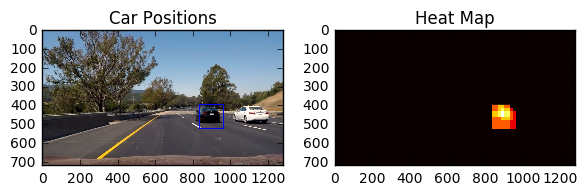

In [19]:
import pickle
from scipy.ndimage.measurements import label
%matplotlib inline

#box_list = hot_windows
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
print('hola', heat.shape)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

print(labels[0].shape)

draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

# Let's make it in a video

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [53]:
def process_frame(image):
    global count
    global hot_windows_list
    global old_labels
    global old_box_label_list
    
    n_frame = 6
    count += 1
    
    # Reset the counter and some variables
    if count > n_frame:
        count = 0
        hot_windows_list = []
    
    # Multi-scale sliding-window detection
    # ------------------------------------
    ystart = (400, 400, 400)
    ystop =  (496, 592, 688)
    scale = (1, 2, 3)
    cells_per_step = (2, 2, 2)
    
    hot_windows_list_one_frame = []
    for i in range(len(scale)):
        hot_windows = find_cars(image, ystart[i], ystop[i], scale[i], svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step[i])
         
        hot_windows_list_one_frame.append(hot_windows)
    
    # Add to the list of detection, the last list of detection:
    # ---------------------------------------------------------
    hot_windows_list_one_frame.append(old_box_label_list)
    
    # Combine overlapping detections and remove false positives.
    # --------------------------------------
    
    # Make a unike list.
    boxes = [y for x in hot_windows_list_one_frame for y in x]
    # heat variable initialization.
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list.
    heat = add_heat(heat,boxes)
    # Apply threshold to help remove false positives.
    heat = apply_threshold(heat,1)
    # Find final boxes from heatmap using label function.
    labels = label(heat)
    # Extract the final coordinates do the windows of this image frame.
    boxes = labels2boxes(labels)
    
    # Add to a global list the final windows of this frame.
    hot_windows_list.append(boxes)
    
    # Every n_frame do the follow:
    # Combine the n_frame-1 frame detection with the last final 
    # output detection and combine overlapping detections and 
    # remove false positives.
    #-------------------------------------------
    if count == n_frame:
        # Add to the list of detection, the last list of detection:
        hot_windows_list.append(old_box_label_list)
        hot_windows_list.append(old_box_label_list)
        
        # Make a unike list.
        box_list = [y for x in hot_windows_list for y in x]
        # heat variable initialization.
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        # Extract the final coordinates do the windows.
        box_label_list = labels2boxes(labels)
        # Draw on the image the finding windows
        draw_img = draw_boxes(np.copy(image), box_label_list, color=(0, 0, 255), thick=4)
        
        # Save as old (last) detections
        old_labels = labels
        old_box_label_list = box_label_list #box_list 
        
        return draw_img
    else:
        
        draw_img = draw_labeled_bboxes(np.copy(image), old_labels)
        return draw_img
    

In [54]:
# Some variable that need to be initizaliate it
count = 0
hot_windows_list = []
heat = np.zeros_like(image[:,:,0]).astype(np.float)
old_labels = label(heat)
old_box_label_list = []

white_output = 'video_result.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_result.mp4
[MoviePy] Writing video output_images/test_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:34<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_result.mp4 

Wall time: 18min 37s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))